# Ensemble Models:

Here I will be performing the same task performed in ECFP4_random_split_Linear_Models.ipynb, but using ensemble models. The chosen models will be a Random Forest (RF) regressor and a Gradient Boosting Machine (GBM), using Xgboost or LightGBM. 

In [29]:
# Standard
import os
import joblib

# Third-party
import deepchem as dc
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from optuna.samplers import TPESampler
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Own-coded
from measurements import nRMSE
from utils import get_similarity, load_bace

# Make all the figures have Times New Roman font, and 16 font size
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16


In [21]:
# Load BACE regression dataset
dfs = load_bace(splitter = dc.splits.RandomSplitter())
df_train, df_valid, df_test = dfs
smiles = df_train.smiles.values.tolist()
similarity_matrix, fingerprints, mols = get_similarity(smiles)
df = pd.DataFrame(similarity_matrix, index=smiles, columns=smiles)

df_train = df_train.set_index('smiles')
df_valid = df_valid.set_index('smiles')
df_test = df_test.set_index('smiles')

X = df_train.drop(columns=['targets'])
y = df_train.targets.values
x_valid = df_valid.drop(columns=['targets'])
y_valid = df_valid.targets.values
# X and x_valid are the new X_train
# y and y_valid are the new y_train
X_train = pd.concat([X, x_valid])
y_train = np.concatenate([y, y_valid])
x_test = df_test.drop(columns=['targets'])
y_test = df_test.targets.values

## Random Forest Regressor

In [3]:

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 64)
    reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
    # Cross-validation
    r2 = cross_val_score(reg, X_train, y_train, cv=5, scoring='r2').mean()
    return r2

study = optuna.create_study(direction='maximize', sampler=TPESampler(), study_name='RandomForest')
study.optimize(objective, n_trials=100, n_jobs=-1)
study.best_params

[I 2024-09-08 21:10:47,330] A new study created in memory with name: RandomForest
/Users/cesarasa/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2024-09-08 21:11:40,462] Trial 9 finished with value: 0.6804757552474776 and parameters: {'n_estimators': 273, 'max_depth': 63}. Best is trial 9 with value: 0.6804757552474776.
[I 2024-09-08 21:11:46,196] Trial 2 finished with value: 0.679860198038521 and parameters: {'n_estimators': 306, 'max_depth': 34}. Best is trial 9 with value: 0.6804757552474776.
[I 2024-09-08 21:11:47,421] Trial 6 finished with value: 0.6797472237025086 and parameters: {'n_estimators': 305, 'max_depth': 49}. Best is trial 9 with value: 0.6804757552474776.
[I 2024-09-08 21:11:54,886] Trial 3 finished with value: 0.6788303267766693 and parameters: {'n_estimat

{'n_estimators': 98, 'max_depth': 57}

In [26]:
# Cross-validation using several metrics:
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=10, n_repeats=1)
nrmse_, r2_, mse_, rmse_, pcc_ = [], [], [], [], []
for train_index, test_index in rkf.split(X_train):
    x_train_, x_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_, y_val = y_train[train_index], y_train[test_index]
    reg = RandomForestRegressor(n_estimators=100, max_depth=60, random_state=0)
    reg.fit(x_train_, y_train_)
    y_pred = reg.predict(x_val)
    nrmse, r2, mse, rmse = nRMSE(y_val, y_pred)
    pcc = np.corrcoef(y_val, y_pred)[0, 1]
    nrmse_.append(nrmse)
    r2_.append(r2)
    mse_.append(mse)
    rmse_.append(rmse)
    pcc_.append(pcc)
    

Cross-Validated Results on the Training Set [RandomForest]
nRMSE: 0.539
R2: 0.708
MSE: 0.285
RMSE: 0.533
PCC: 0.845
Test Set Results [RandomForest]
nRMSE: 0.507
R2: 0.742
MSE: 0.255
RMSE: 0.505
PCC: 0.869


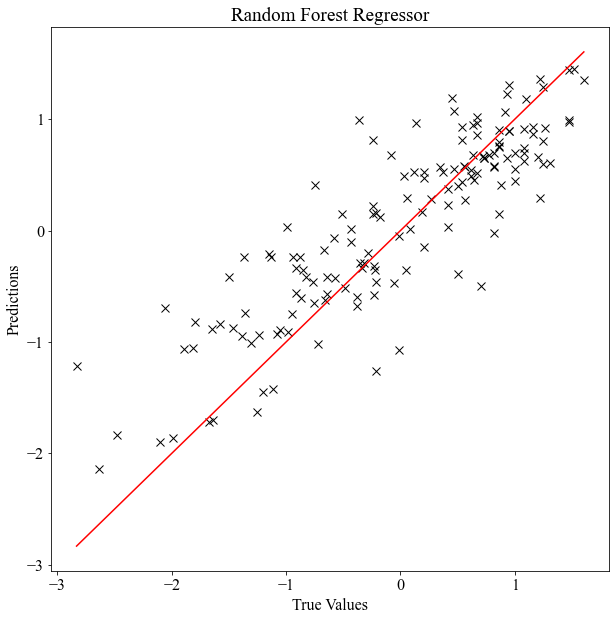

In [31]:
nrmse_mean = np.mean(nrmse_)
r2_mean = np.mean(r2_)
mse_mean = np.mean(mse_)
rmse_mean = np.mean(rmse_)
pcc_mean = np.mean(pcc_)

print('Cross-Validated Results on the Training Set [RandomForest]')
print(f"nRMSE: {nrmse_mean:.3f}")
print(f"R2: {r2_mean:.3f}")
print(f"MSE: {mse_mean:.3f}")
print(f"RMSE: {rmse_mean:.3f}")
print(f"PCC: {pcc_mean:.3f}")

# Test set:
reg = RandomForestRegressor(n_estimators=100, max_depth=60, random_state=0)
reg.fit(X_train, y_train)
y_pred = reg.predict(x_test)
nrmse, r2, mse, rmse = nRMSE(y_test, y_pred)
pcc = np.corrcoef(y_test, y_pred)[0, 1]

print('Test Set Results [RandomForest]')
print(f"nRMSE: {nrmse:.3f}")
print(f"R2: {r2:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"PCC: {pcc:.3f}")

# Plot predictions vs true values
plt.figure(figsize=(10, 10))
plt.plot(y_test, y_pred, 'kx', markersize=8)
# Plot line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Random Forest Regressor')

# Create figures folder
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig('figures/rf_regression_plot.png')
plt.show()

## Xgboost Regressor

In [34]:
# Optuna study for the XGBOOST regressor
def optimize(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 64)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    reg = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    # Cross-validation
    r2 = cross_val_score(reg, X_train, y_train, cv=5, scoring='r2').mean()
    return r2

study2 = optuna.create_study(direction='maximize', sampler=TPESampler(), study_name='XGBoost')
study2.optimize(optimize, n_trials=100, n_jobs=-1)
study2.best_params

[I 2024-09-08 21:44:01,347] A new study created in memory with name: XGBoost
/Users/cesarasa/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
